In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from datetime import datetime

In [16]:
# Load the datasets
plant_gen_data = pd.read_csv('/content/Plant_1_Generation_Data.csv')
weather_sensor_data = pd.read_csv('/content/Plant_1_Weather_Sensor_Data.csv')

# Display the first few rows of the date columns from both datasets to understand the formats
plant_gen_data_head = plant_gen_data.head()
weather_sensor_data_head = weather_sensor_data.head()

(plant_gen_data_head, weather_sensor_data_head)

(          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
 0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
 1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
 2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
 3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
 4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   
 
    DAILY_YIELD  TOTAL_YIELD  
 0          0.0    6259559.0  
 1          0.0    6183645.0  
 2          0.0    6987759.0  
 3          0.0    7602960.0  
 4          0.0    7158964.0  ,
         DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
 0  5/15/2020 0:00   4135001  HmiyD2TTLFNqkNe            25.184316   
 1  5/15/2020 0:15   4135001  HmiyD2TTLFNqkNe            25.084589   
 2  5/15/2020 0:30   4135001  HmiyD2TTLFNqkNe            24.935753   
 3  5/15/2020 0:45   4135001  HmiyD2TTLFNqkNe            24.846130   
 4  5/15/2020 1:00   4135001  HmiyD

In [17]:
def convert_date_format_safe(date_str):
  try:
        # Try to parse the date string to datetime object with the expected format
        date_obj = datetime.strptime(date_str, '%d-%m-%Y %H:%M')
  except ValueError:
        # If there's a ValueError, it means the date string is already in the desired format
        return date_str

    # Convert the datetime object to the new string format
  new_date_str = date_obj.strftime('%-m/%-d/%Y %-H:%M')

  return new_date_str

In [18]:
# Apply the safe conversion function to the entire date column of the plant generation dataset
plant_gen_data['DATE_TIME'] = plant_gen_data['DATE_TIME'].apply(convert_date_format_safe)

# Verify the conversion by displaying the first few rows
plant_gen_data

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,5/15/2020 0:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,5/15/2020 0:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,5/15/2020 0:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,5/15/2020 0:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,5/15/2020 0:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,6/17/2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,6/17/2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,6/17/2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,6/17/2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


In [19]:
# Merge the two datasets on the 'DATE_TIME' column
merged_data = pd.merge(plant_gen_data, weather_sensor_data, on='DATE_TIME', how='inner', suffixes=('_gen', '_weather'))

# Display the first few rows of the merged dataset to confirm the merge
merged_data.head()

,DATE_TIME,PLANT_ID_gen,SOURCE_KEY_gen,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_weather,SOURCE_KEY_weather,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,5/15/2020 0:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,5/15/2020 0:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,5/15/2020 0:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,5/15/2020 0:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,5/15/2020 0:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


In [20]:
# Convert 'DATE_TIME' to datetime
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])

# Set 'DATE_TIME' as the index
merged_data.set_index('DATE_TIME', inplace=True)

# Resample data to hourly intervals, taking the mean for each hour
daily_data = merged_data.resample('D').mean().dropna()

# Define the create_sequences function for hourly data
def create_sequences_daily(data, feature_columns, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[feature_columns].iloc[i:i+sequence_length].values)
        y.append(data[target_column].iloc[i+sequence_length])
    return np.array(X), np.array(y)

# Define sequence length and feature columns for hourly prediction
sequence_length = 2
feature_columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
# feature_columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER', 'AC_POWER']


# Create sequences using the daily data
X, y = create_sequences_daily(daily_data, feature_columns, 'DAILY_YIELD', sequence_length)

# Display the shape of the data
print(X.shape, y.shape)


(21, 2, 3) (21,)


<ipython-input-20-d3ffa916e64f>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = merged_data.resample('D').mean().dropna()


In [21]:
merged_data

,PLANT_ID_gen,SOURCE_KEY_gen,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_weather,SOURCE_KEY_weather,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,,,,
2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


In [22]:
# Split the data into training, validation, and test sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train_temp.reshape(-1, X_train_temp.shape[-1])).reshape(X_train_temp.shape)

# Transform the validation data
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Transform the test data
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [35]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(feature_columns))))
model.add(Dense(1))

# model = Sequential()
# # First LSTM layer with Dropout regularisation
# model.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=(sequence_length, len(feature_columns))))
# model.add(Dropout(0.2))
# # Second LSTM layer
# model.add(LSTM(units=100, return_sequences=True, activation='relu'))
# model.add(Dropout(0.2))
# # Third LSTM layer
# model.add(LSTM(units=100, activation='relu'))
# model.add(Dropout(0.2))
# # The output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10800     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10851 (42.39 KB)
Trainable params: 10851 (42.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train_temp, epochs=200, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1, callbacks=[early_stopping])


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 12235207.0000 - val_loss: 13286941.0000
Epoch 2/200
1/1 [==============================] - 0s 56ms/step - loss: 12234802.0000 - val_loss: 13286408.0000
Epoch 3/200
1/1 [==============================] - 0s 40ms/step - loss: 12234371.0000 - val_loss: 13285832.0000
Epoch 4/200
1/1 [==============================] - 0s 44ms/step - loss: 12233912.0000 - val_loss: 13285211.0000
Epoch 5/200
1/1 [==============================] - 0s 37ms/step - loss: 12233399.0000 - val_loss: 13284491.0000
Epoch 6/200
1/1 [==============================] - 0s 40ms/step - loss: 12232805.0000 - val_loss: 13283635.0000
Epoch 7/200
1/1 [==============================] - 0s 39ms/step - loss: 12232101.0000 - val_loss: 13282597.0000
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 12231262.0000 - val_loss: 13281345.0000
Epoch 9/200
1/1 [==============================] - 0s 38ms/step - loss: 12230259.0000 - val_loss: 13279853

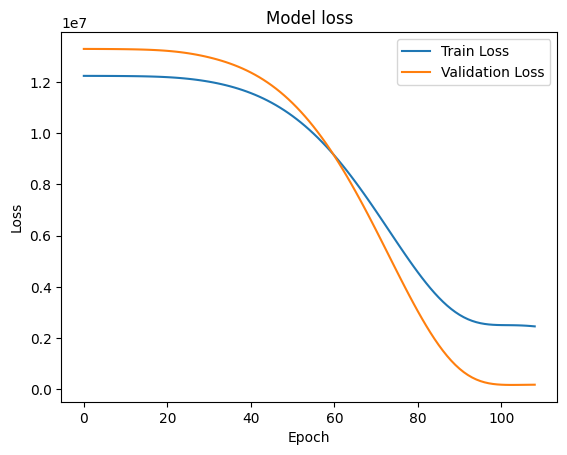

In [37]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [38]:
predictions = model.predict(X_test_scaled)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # RMSE is just the square root of MSE

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')

1/1 [==============================] - 0s 174ms/step
Mean Absolute Error (MAE): 628.918
Mean Squared Error (MSE): 846744.694
Root Mean Squared Error (RMSE): 920.187
